#### Feature Selection

Using SHAP values we can figure out what features are Usless and should be removed from the training data in order to reduce complexity and potentially noise. 

In order to do this I will first need to train an XGBoost model and calculate the SHAP values for each feature. 

In [453]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [454]:
#load data 
data = pd.read_csv('AmesHousing_clean.csv')
train_X = pd.read_csv('train_X')
test_X = pd.read_csv('test_X')
train_y = pd.read_csv('train_y').SalePrice
test_y = pd.read_csv('test_y').SalePrice
y = pd.concat([train_y, test_y])

In [455]:
def buildModel2(train_X, test_X, train_y, test_y, removeFeatures = []):
    train_X = train_X.drop(removeFeatures, axis = 1)
    test_X = test_X.drop(removeFeatures, axis = 1)

    model = XGBRegressor(n_estimators = 1000,
                        max_depth = 6,
                        learning_rate = 0.05,
                        subsample = 0.7,
                        colsample_bytree = 0.8,
                        colsample_bylevel = 0.75,
                        base_score= train_y.mean(),
                        random_state = 42,
                        seed = 42)
    
    model.fit(train_X, train_y, early_stopping_rounds = 5, eval_set = [(test_X, test_y)], eval_metric = 'rmse', verbose = 100)
    return model, train_X, test_X



In [456]:
def findUnwanted(shap_values,feature_names, min):
    unWanted = []
    shap_df = pd.DataFrame(shap_values, columns = feature_names)
    vals = np.abs(shap_df.values).mean(0)
    
    shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns = ['col_name', 'feature_imporatnce_vals'])
    shap_importance = shap_importance.set_index('col_name')

    for i, row in shap_importance.iterrows():
        if shap_importance.loc[i].values <= min:
            unWanted.append(i)
    
    return unWanted


In [457]:
model_1, train_X1, test_X1 = buildModel2(train_X, test_X, train_y, test_y)
model_1.save_model('model_1.bin')

[0]	validation_0-rmse:76404.46394


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[100]	validation_0-rmse:20010.43444
[183]	validation_0-rmse:19222.16339


In [458]:
X1 = pd.concat([train_X1, test_X1])

In [459]:
#Now that the model is trained I will evaluate its performance with cross fold validation
#The metric used to evaluate is Root Mean Squared Error

score_RMSE = cross_val_score(model_1, X1,y, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
score_MAE = cross_val_score(model_1, X1,y, cv = 5, scoring = 'neg_mean_absolute_error').mean()

score = [score_RMSE, score_MAE]
#add score to compare to next model
score_dict = {"model_1":score}
print(score)

[-22307.983583652254, -13557.582628519624]


In [460]:
import shap
shap.initjs()
explainer_SHAP = shap.TreeExplainer(model_1)
shap_values_1a = explainer_SHAP.shap_values(X1)
shap_values_1b = explainer_SHAP(X1)

### Bar plot
We can identify the influential features by ploting the mean absolute SHAP values. This identifies the importance of each features effect on the prediction of sale price. 

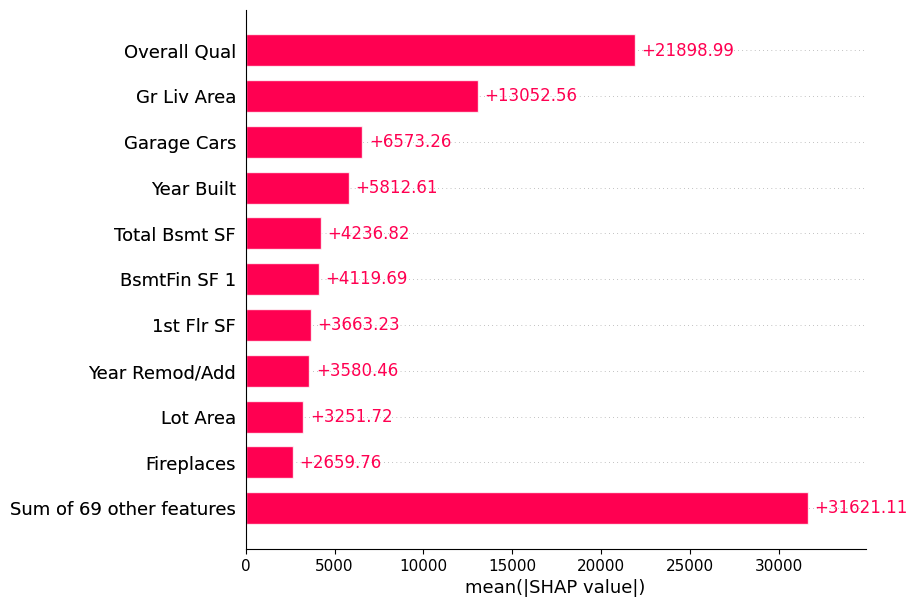

In [461]:
shap.plots.bar(shap_values_1b, max_display = 11)

In [462]:
shap_values_1a.shape

(2930, 79)

In [463]:
np.std(shap_values_1a, axis = 0).shape

(79,)

In [464]:
std_shap = dict(zip(X1.columns, np.std(shap_values_1a, axis = 0)))
var_shap = dict(zip(X1.columns, np.var(shap_values_1a, axis= 0)))

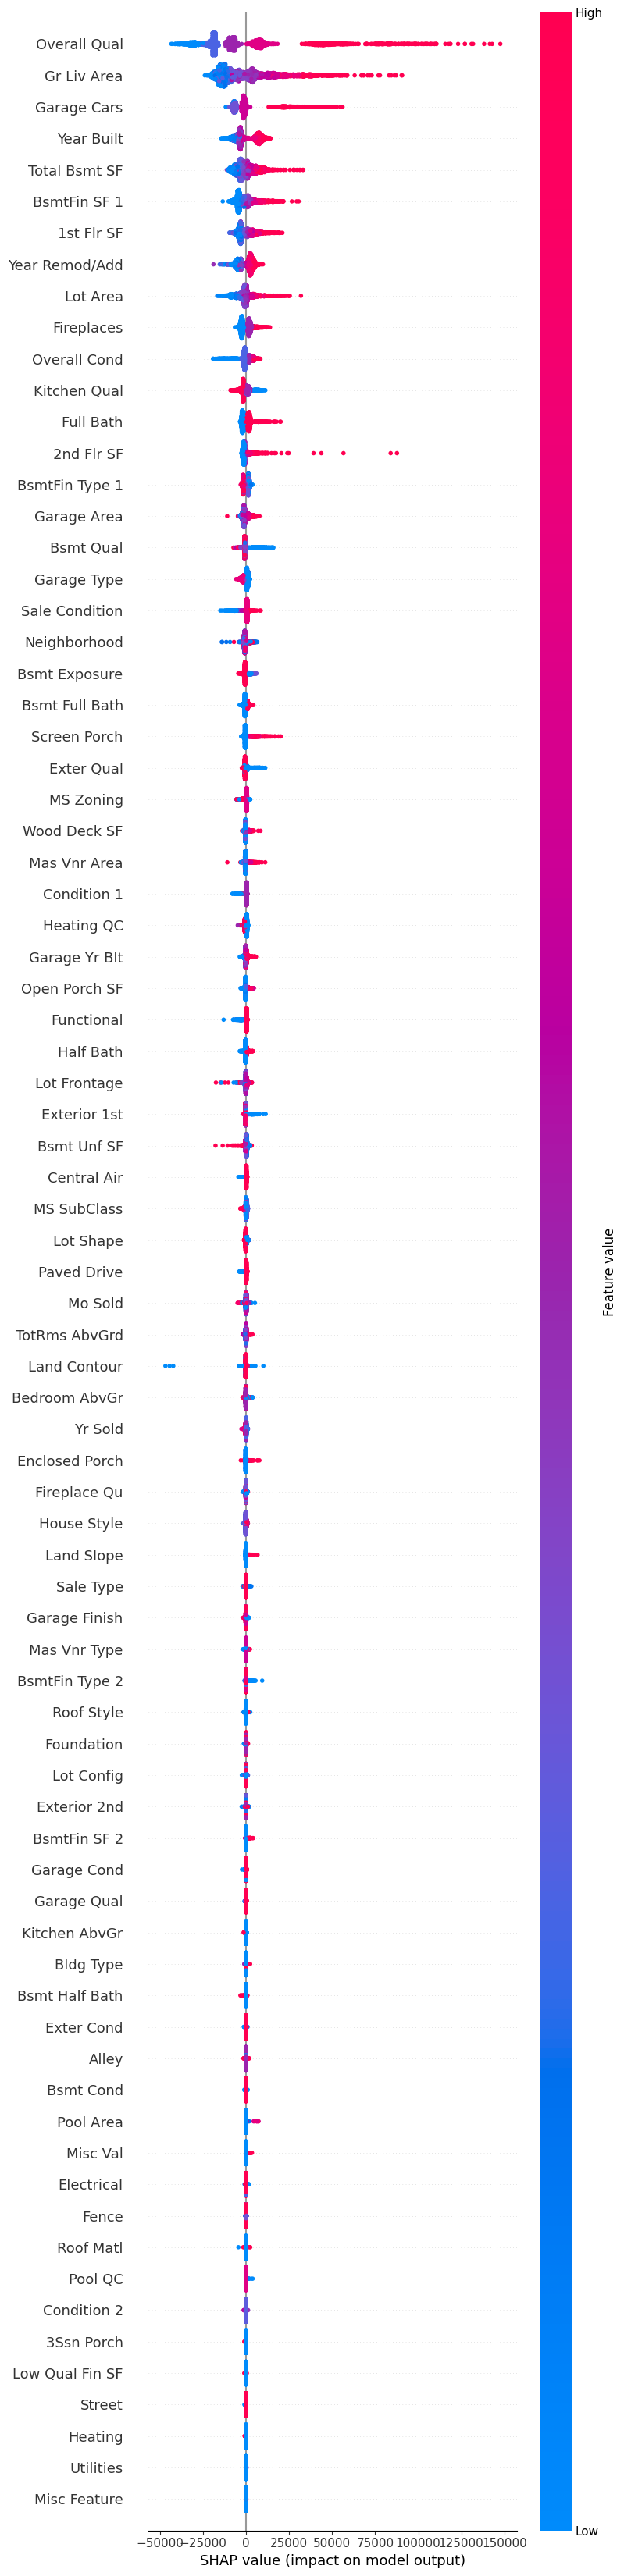

In [465]:
shap.summary_plot(shap_values_1a, X1, max_display=79)

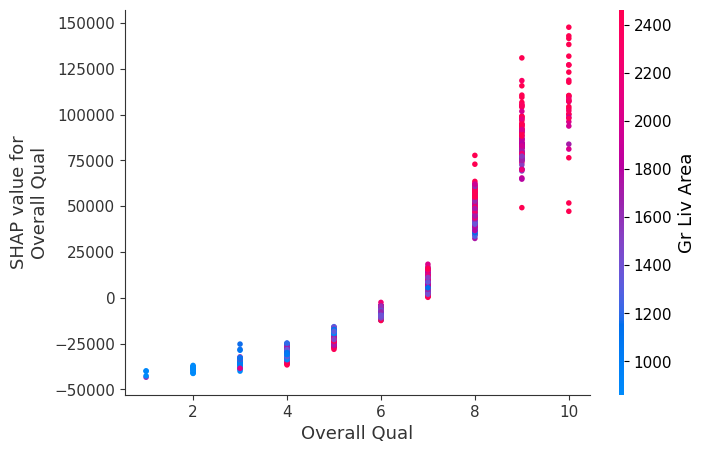

In [466]:
shap.dependence_plot("Overall Qual", shap_values_1a, X1)

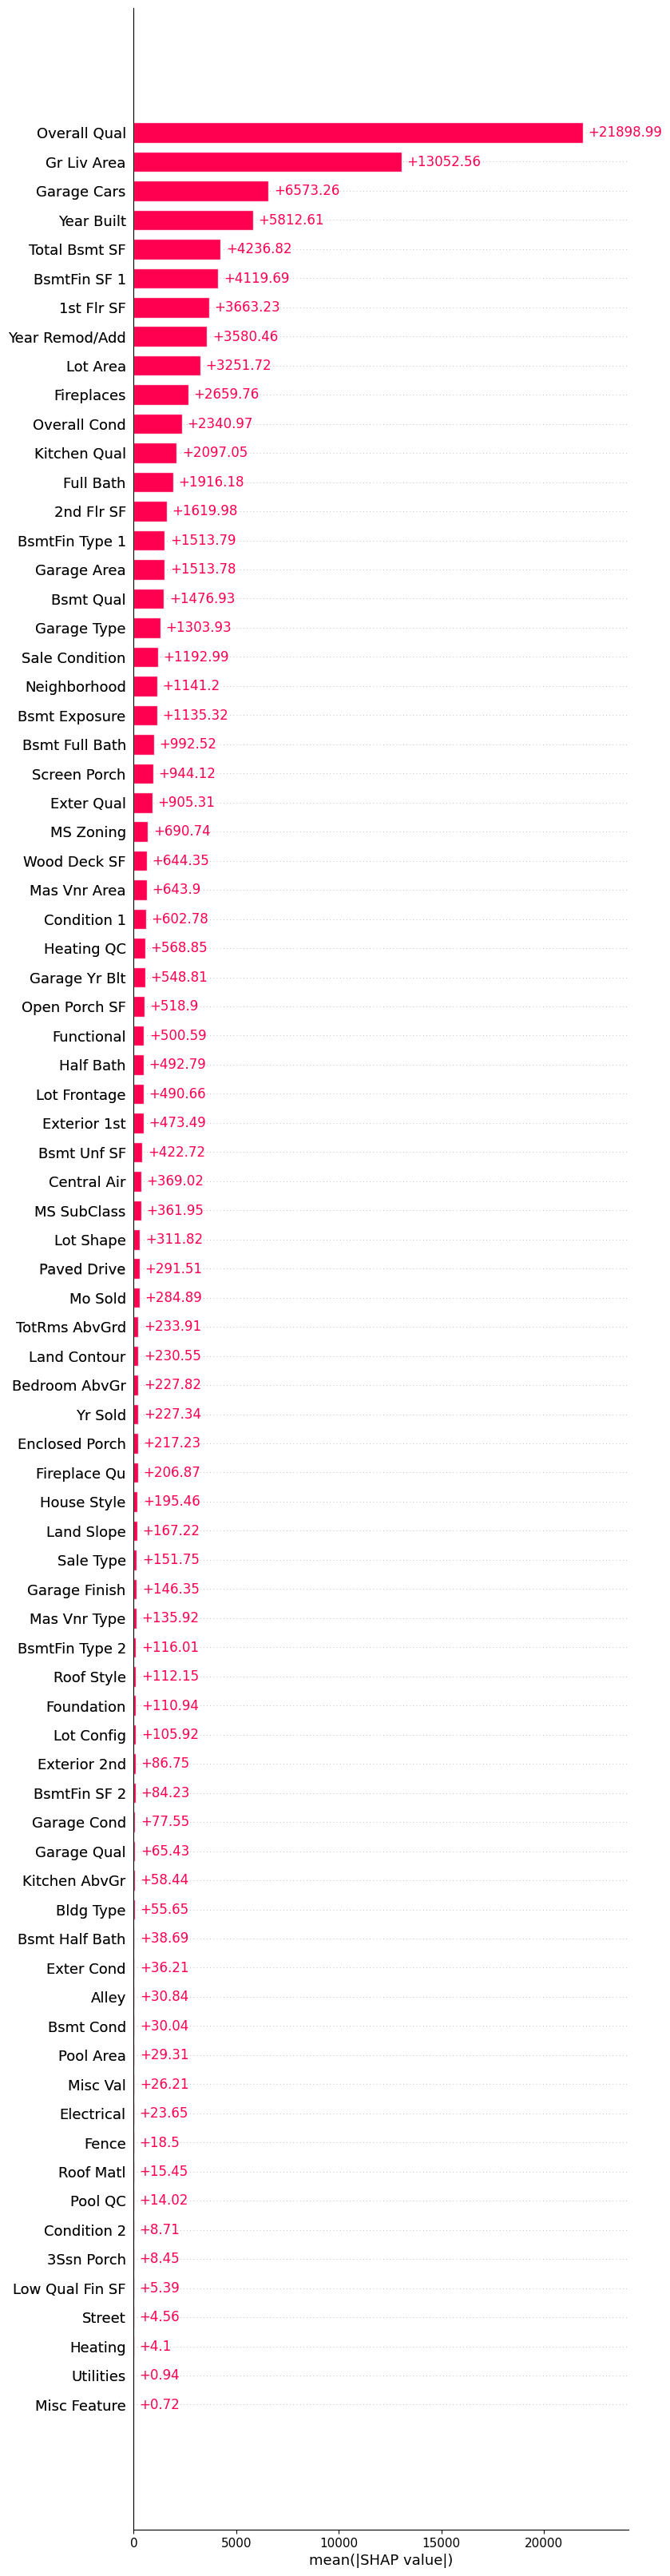

In [467]:
shap.plots.bar(shap_values_1b, max_display=79)

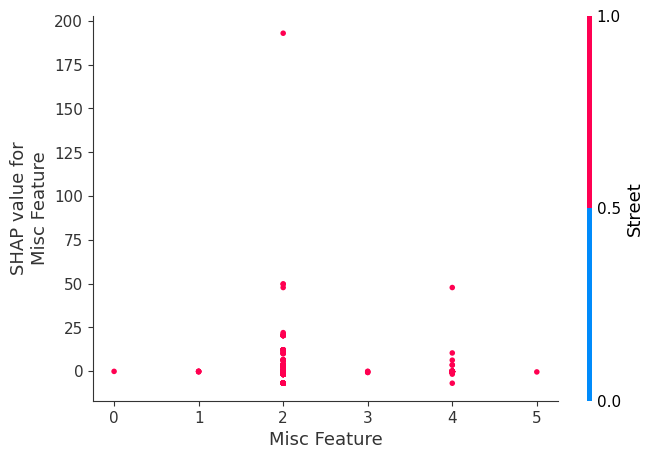

In [468]:
shap.dependence_plot("Misc Feature", shap_values_1a, X, interaction_index='Street')

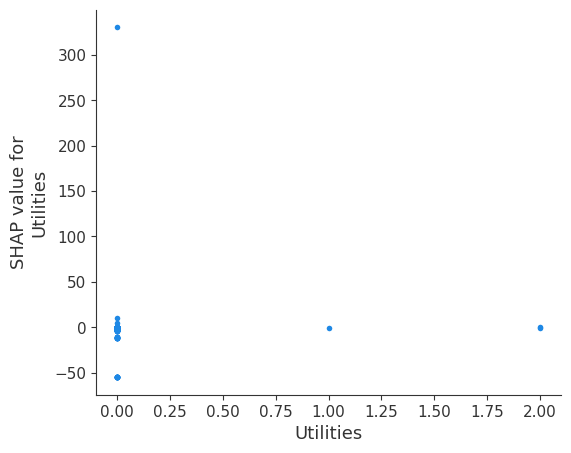

In [469]:
shap.dependence_plot("Utilities", shap_values_1a, X, interaction_index=None)

In [470]:
unWanted1 = findUnwanted(shap_values_1a, X1.columns, 100)

In [471]:
unWanted1

['Street',
 'Alley',
 'Utilities',
 'Condition 2',
 'Bldg Type',
 'Roof Matl',
 'Exterior 2nd',
 'Exter Cond',
 'Bsmt Cond',
 'BsmtFin SF 2',
 'Heating',
 'Electrical',
 'Low Qual Fin SF',
 'Bsmt Half Bath',
 'Kitchen AbvGr',
 'Garage Qual',
 'Garage Cond',
 '3Ssn Porch',
 'Pool Area',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Misc Val']

In [472]:
#Load in data set again 
train_X2 = pd.read_csv('train_X')
test_X2 = pd.read_csv('test_X')


model_2, train_X2, test_X2 = buildModel2(train_X2, test_X2, train_y, test_y, unWanted1)
model_2.save_model('model_2.bin')

X2 = pd.concat([train_X2, test_X2])

[0]	validation_0-rmse:76749.07348


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[100]	validation_0-rmse:20434.27585
[178]	validation_0-rmse:19642.26215


In [473]:
#Now lets score the new model 

score_RMSE2 = cross_val_score(model_2, X2,y, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
score_MAE2 = cross_val_score(model_2, X2,y, cv = 5, scoring = 'neg_mean_absolute_error').mean()

#add score to compare to next model
score_dict['model_2'] = [score_RMSE2, score_MAE2]

In [ ]:
score_dict

{'model_1': [-22307.983583652254, -13557.582628519624],
 'model_2': [-22503.911357715304, -13555.75613267918]}

In [ ]:
explainer_SHAP2 = shap.TreeExplainer(model_2)
shap_values_2a = explainer_SHAP2.shap_values(X2)
shap_values_2b = explainer_SHAP2(X2)


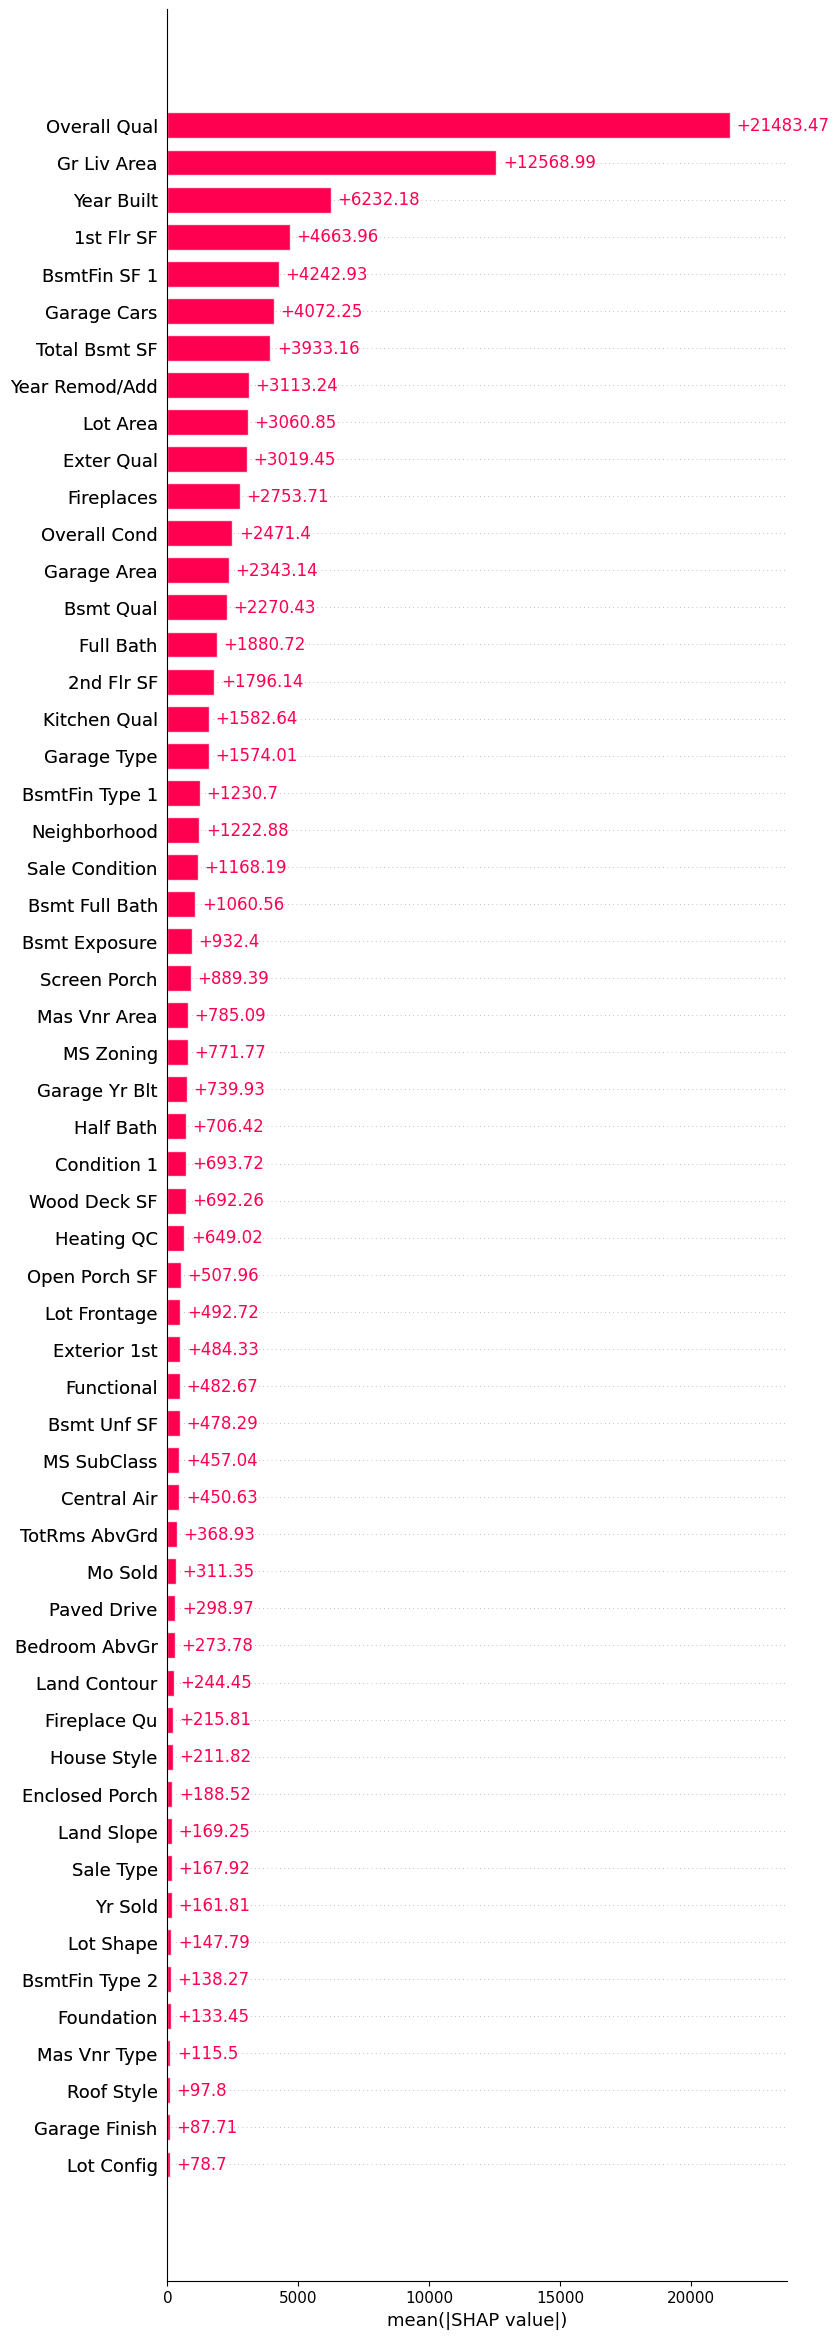

In [ ]:
shap.plots.bar(shap_values_2b, max_display=79)

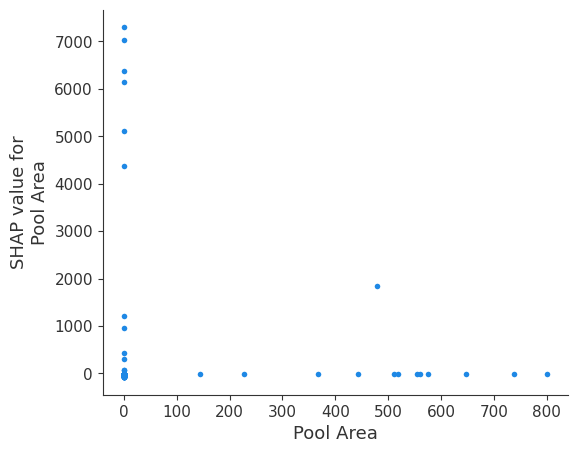

In [ ]:
shap.dependence_plot("Pool Area", shap_values_1a, X, interaction_index=None) 

In [ ]:
#Load in data set again 
train_X3 = pd.read_csv('train_X')
test_X3 = pd.read_csv('test_X')
unWanted2 = findUnwanted(shap_values_2a, X2.columns, 250)

model_3, train_X3, test_X3 = buildModel2(train_X3, test_X3, train_y, test_y, unWanted2)
model_3.save_model('model_3.bin')

X3 = pd.concat([train_X3, test_X3])

[0]	validation_0-rmse:76563.32719


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[100]	validation_0-rmse:22608.54539
[161]	validation_0-rmse:21949.75592


In [ ]:
unWanted2

['Lot Shape',
 'Land Contour',
 'Lot Config',
 'Land Slope',
 'House Style',
 'Roof Style',
 'Mas Vnr Type',
 'Foundation',
 'BsmtFin Type 2',
 'Fireplace Qu',
 'Garage Finish',
 'Enclosed Porch',
 'Yr Sold',
 'Sale Type']

In [ ]:

score_RMSE3 = cross_val_score(model_3, X3,y, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
score_MAE3 = cross_val_score(model_3, X3,y, cv = 5, scoring = 'neg_mean_absolute_error').mean()

#add score to compare to next model
score_dict['model_3'] = [score_RMSE3, score_MAE3]

In [ ]:
score_dict

{'model_1': [-22307.983583652254, -13557.582628519624],
 'model_2': [-22503.911357715304, -13555.75613267918],
 'model_3': [-23048.72474782265, -13586.277550394623]}

In [ ]:
explainer_SHAP3 = shap.TreeExplainer(model_3)
shap_values_3a = explainer_SHAP3.shap_values(X3)
shap_values_3b = explainer_SHAP3(X3)

In [ ]:
#create one more model with the removal of more features. 

train_X4 = pd.read_csv('train_X')
test_X4 = pd.read_csv('test_X')
unWanted3 = findUnwanted(shap_values_3a, X3.columns, 500)

model_4, train_X4, test_X4 = buildModel2(train_X4, test_X4, train_y, test_y, unWanted3)
model_4.save_model('model_4.bin')

X4 = pd.concat([train_X4, test_X4])

[0]	validation_0-rmse:76446.82885


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[100]	validation_0-rmse:21904.25812
[174]	validation_0-rmse:21248.31689


In [ ]:

score_RMSE4 = cross_val_score(model_4, X4,y, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
score_MAE4 = cross_val_score(model_4, X4,y, cv = 5, scoring = 'neg_mean_absolute_error').mean()

#add score to compare to next model
score_dict['model_4'] = [score_RMSE4, score_MAE4]

In [ ]:
score_dict

{'model_1': [-22307.983583652254, -13557.582628519624],
 'model_2': [-22503.911357715304, -13555.75613267918],
 'model_3': [-23048.72474782265, -13586.277550394623],
 'model_4': [-22468.266862755136, -13587.764615774318]}